## Imports

In [1]:
import fsspec
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import warnings
import pandas as pd
import itertools
from IPython.display import HTML
from datetime import datetime
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed, compute
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib.animation import FuncAnimation, FFMpegWriter

warnings.filterwarnings('ignore')

In [2]:
# cluster = SLURMCluster(queue="seseml",
#                        memory='50GB',
#                        cores=40,
#                        processes=1,
#                        walltime='24:00:00', 
# #                        scheduler_options={
# #                            'host': '172.22.179.3:7224', 
# #                            'dashboard_address': ':7798'
# #                        }
#                       )

# cluster.scale(jobs=1)
# client = Client(cluster)

In [3]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1655795    seseml interact alfonso8  R       3:26      1 keeling-j17


In [4]:
def create_query(date, band='C01'):
    """
    Creates a query for listing GOES16 files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param band: Goes16 band to be queried e.g. C01
    :return: string with a
    """
    prefix = f'ABI-L1b-RadF/{date:%Y}/{date.timetuple().tm_yday:03d}/{date:%H}/OR_ABI-L1b-RadF-M6{band}_G16_s' \
             f'{date:%Y}{date.timetuple().tm_yday:03d}*'
    return prefix

def open_local(file):
    return fsspec.open_local(
        f"simplecache::{file}",
        s3={"anon": True},
        filecache={"cache_storage": "'/tmp/files/'"})

def get_files(date_start, date_end, band):
    str_bucket = 's3://noaa-goes16/'
    # fs = fsspec.filesystem("s3", anon=True)
    fs = fsspec.filesystem("simplecache",
                           cache_storage='/data/keeling/a/alfonso8/accp/goes/files/',
                           # use file.nc names over random hashes b/c rasterio selects netCDF instead of HDF and picks up metadata:
                           same_names=True,
                           target_protocol='s3',
                           target_options={'anon': True},
                           )
    date_range = pd.date_range(date_start, date_end, freq='1H')
    files = []
    for i in date_range:
        query = create_query(i, band=band)
        files.append([fs.open(f"s3://{i}") for i in sorted(fs.glob(f"{str_bucket}{query}"))])
    return list(itertools.chain.from_iterable(files))
    

def calc_latlon(ds):
    # The math for this function was taken from
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection

    x, y = np.meshgrid(x, y)

    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi / 180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat

    a = np.sin(x) ** 2 + (np.cos(x) ** 2 * (np.cos(y) ** 2 + (r_eq ** 2 / r_pol ** 2) * np.sin(y) ** 2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H ** 2 - r_eq ** 2

    r_s = (-b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)

    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)

    lat = np.arctan((r_eq ** 2 / r_pol ** 2) * (s_z / np.sqrt((H - s_x) ** 2 + s_y ** 2))) * (180 / np.pi)
    lon = (l_0 - np.arctan(s_y / (H - s_x))) * (180 / np.pi)
    ds = ds.assign_coords({"lat": np.nanmax(lat, axis=1),
                           "lon": np.nanmax(lon, axis=0)})
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds


def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data

    x = ds.x.data
    y = ds.y.data

    x, y = np.meshgrid(x, y)

    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]

    return ((np.nanmin(x), np.nanmax(x)), (np.nanmin(y), np.nanmax(y)))


def goes16_ds(date_start, date_end, band='C01'):
    files = get_files(date_start, date_end, band=band)
    ds = xr.open_mfdataset(files, engine='h5netcdf', concat_dim='t', combine='nested')
    return ds


def normalization(da, vmin, vmax, gamma):
    norm = (da - vmin) / (vmax - vmin)
    norm = np.clip(norm, 0, 1)
    return np.power(norm, gamma)


def rad2tb(ds):
        """
        https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Imagery.pdf pag 22
        """
        fk1 = ds['planck_fk1']
        fk2 = ds['planck_fk2']
        bc1 = ds['planck_bc1']
        bc2 = ds['planck_bc2']
        bt = ((fk2 / (np.log((fk1 / ds.Rad) + 1))) - bc1) / bc2
        return bt


def vol_ash(ds11, ds13, ds14, ds15):
    r = rad2tb(ds15) - rad2tb(ds13)
    g = rad2tb(ds14) - rad2tb(ds11)
    b = rad2tb(ds13)
    # normalization
    r = normalization(r, vmin=-6.7, vmax=2.6, gamma=1)
    g = normalization(g, vmin=-6.0, vmax=6.3, gamma=1)
    b = normalization(b, vmin=243.6, vmax=302.4, gamma=1)
    rgb = np.dstack([r, g, b])
    return rgb


In [5]:
d_s = datetime(2023, 4, 18, 11)
d_e = datetime(2023, 4, 18, 13)

In [6]:
%%time
ds11 = goes16_ds(date_start=d_s, date_end=d_e, band="C11").sel(x=slice(-0.025, 0.03)).sel(y=slice(0.04, -0.01))

CPU times: user 5.92 s, sys: 2.77 s, total: 8.7 s
Wall time: 41.2 s


In [7]:
%%time
ds13 = goes16_ds(date_start=d_s, date_end=d_e, band="C13").sel(x=slice(-0.025, 0.03)).sel(y=slice(0.04, -0.01))
ds14 = goes16_ds(date_start=d_s, date_end=d_e, band="C14").sel(x=slice(-0.025, 0.03)).sel(y=slice(0.04, -0.01))
ds15 = goes16_ds(date_start=d_s, date_end=d_e, band="C15").sel(x=slice(-0.025, 0.03)).sel(y=slice(0.04, -0.01))

CPU times: user 13.6 s, sys: 6.14 s, total: 19.8 s
Wall time: 2min 3s


In [8]:
%%time
rgb = vol_ash(ds11=ds11.isel(t=0), ds13=ds13.isel(t=0), ds14=ds14.isel(t=0), ds15=ds15.isel(t=0))

CPU times: user 1.88 s, sys: 308 ms, total: 2.18 s
Wall time: 1.97 s


In [9]:
%%time
dat = ds11.isel(t=0).metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs
sat_h = ds11.goes_imager_projection.perspective_point_height
sat_h
x = ds11.x * sat_h
y = ds11.y * sat_h
cart_crs = ccrs.PlateCarree()
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=geos)

im = ax.imshow(rgb, origin='upper',
                   transform=geos,
                   extent=(x.min(), x.max(), y.min(), y.max()))

gl = ax.gridlines(crs=cart_crs, draw_labels=True, 
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
ax.coastlines(resolution='10m', color='white', linewidth=0.5)
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
title = ax.text(0.5,0.9, f"", 
                bbox={'facecolor':'white', 'alpha':0.5, 'pad':4},
                transform=ax.transAxes, ha="center", fontsize=8)

shape_feature = ShapelyFeature(Reader('./shape/Departamentos.shp').geometries(),
                               cart_crs, facecolor='none', edgecolor='white', linewidth=0.3)
ax.add_feature(shape_feature)
ax.scatter([-75.31], [4.89], transform=cart_crs, zorder=1, c='red', s=1)
plt.tight_layout()

def update_fig(t):
    rgb = vol_ash(ds11=ds11.isel(t=t), ds13=ds13.isel(t=t), ds14=ds14.isel(t=t), ds15=ds15.isel(t=t))
    title.set_text( f"GOES 16 - RGB Volcanic Ash - {pd.to_datetime(ds11.isel(t=t).t.values).strftime('%Y-%m-%d %X')} UTC")
    im.set_array(rgb)
    
ani = FuncAnimation(fig, update_fig, frames=list(range(len(ds11.t))), interval=150)
plt.close()
HTML(ani.to_html5_video())

CPU times: user 51.2 s, sys: 12.1 s, total: 1min 3s
Wall time: 51.1 s


In [16]:
%%time
FFwriter = FFMpegWriter()
ani.save(f"./results/animation_Col_{pd.to_datetime(d_s).strftime('%Y%m%d_%H%M')}-{pd.to_datetime(d_e).strftime('%Y%m%d_%H%M')}_vol_ash.mp4", writer=FFwriter)

CPU times: user 39.6 s, sys: 10.7 s, total: 50.3 s
Wall time: 38.9 s


In [11]:
%%time
ds111 = ds11.sel(x=slice(-0.006, 0.004)).sel(y=slice(0.02, 0.01))
ds133 = ds13.sel(x=slice(-0.006, 0.004)).sel(y=slice(0.02, 0.01))
ds144 = ds14.sel(x=slice(-0.006, 0.004)).sel(y=slice(0.02, 0.01))
ds155 = ds15.sel(x=slice(-0.006, 0.004)).sel(y=slice(0.02, 0.01))

CPU times: user 7.03 ms, sys: 662 µs, total: 7.69 ms
Wall time: 7.48 ms


In [12]:
%%time
rgb = vol_ash(ds11=ds111.isel(t=0), ds13=ds133.isel(t=0), ds14=ds144.isel(t=0), ds15=ds155.isel(t=0))

CPU times: user 1.86 s, sys: 218 ms, total: 2.08 s
Wall time: 1.87 s


In [17]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=geos)
x = ds111.x * sat_h
y = ds111.y * sat_h
im = ax.imshow(rgb, origin='upper',
                   transform=geos,
                   extent=(x.min(), x.max(), y.min(), y.max()))

gl = ax.gridlines(crs=cart_crs, draw_labels=True, 
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
ax.coastlines(resolution='10m', color='white', linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
title = ax.text(0.5,0.9, f"", 
                bbox={'facecolor':'white', 'alpha':0.5, 'pad':4},
                transform=ax.transAxes, ha="center", fontsize=8)

shape_feature = ShapelyFeature(Reader('./shape/Departamentos.shp').geometries(),
                               cart_crs, facecolor='none', edgecolor='white', linewidth=0.5)
ax.add_feature(shape_feature)

ax.scatter([-75.31], [4.89], transform=cart_crs, zorder=1, c='red', s=1)
plt.tight_layout()

def update_fig(t):
    rgb = vol_ash(ds11=ds111.isel(t=t), ds13=ds133.isel(t=t), ds14=ds144.isel(t=t), ds15=ds155.isel(t=t))
    title.set_text( f"GOES 16 - RGB Volcanic Ash - {pd.to_datetime(ds11.isel(t=t).t.values).strftime('%Y-%m-%d %X')} UTC")
    im.set_array(rgb)
    
ani = FuncAnimation(fig, update_fig, frames=list(range(len(ds11.t))), interval=150)
plt.close()
HTML(ani.to_html5_video())

In [18]:
%%time
FFwriter = FFMpegWriter()
ani.save(f"./results/animation_{pd.to_datetime(d_s).strftime('%Y%m%d_%H%M')}-{pd.to_datetime(d_e).strftime('%Y%m%d_%H%M')}_vol_ash.mp4", writer=FFwriter)

CPU times: user 40 s, sys: 10.6 s, total: 50.6 s
Wall time: 39.4 s


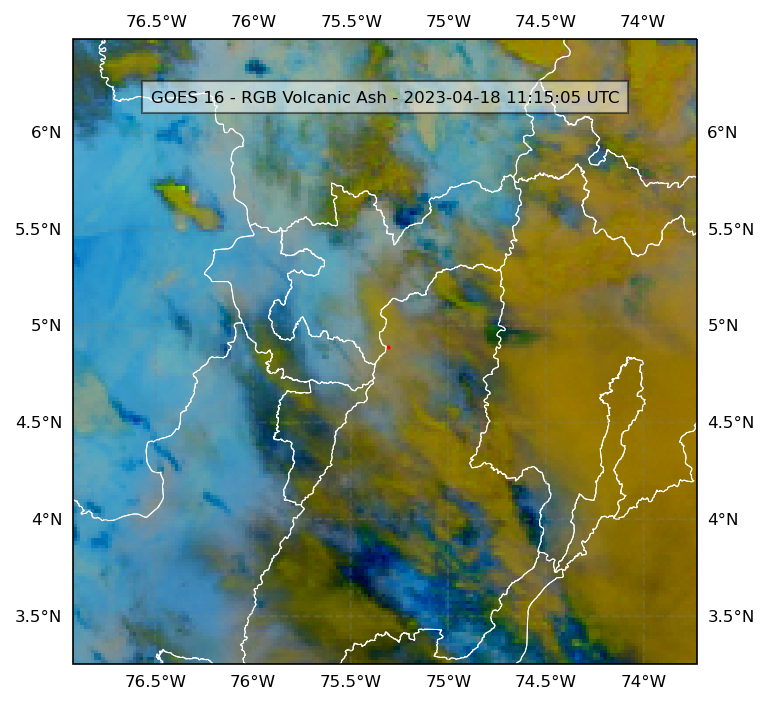

In [19]:
t=1
dat = ds11.isel(t=0).metpy.parse_cf('Rad')
geos = dat.metpy.cartopy_crs
rgb = vol_ash(ds11=ds111.isel(t=t), ds13=ds133.isel(t=t), ds14=ds144.isel(t=t), ds15=ds155.isel(t=t))
fig = plt.figure(dpi=150)
ax = fig.add_subplot(1, 1, 1, projection=geos)
sat_h = ds11.goes_imager_projection.perspective_point_height
x = ds111.x * sat_h
y = ds111.y * sat_h
im = ax.imshow(rgb, origin='upper',
                   transform=geos,
                   extent=(x.min(), x.max(), y.min(), y.max()))

gl = ax.gridlines(crs=cart_crs, draw_labels=True, 
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
ax.coastlines(resolution='10m', color='white', linewidth=0.5)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
title = ax.text(0.5,0.9, f"", 
                bbox={'facecolor':'white', 'alpha':0.5, 'pad':4},
                transform=ax.transAxes, ha="center", fontsize=8)
title.set_text( f"GOES 16 - RGB Volcanic Ash - {pd.to_datetime(ds111.isel(t=t).t.values).strftime('%Y-%m-%d %X')} UTC")
shape_feature = ShapelyFeature(Reader('./shape/Departamentos.shp').geometries(),
                               cart_crs, facecolor='none', edgecolor='white', linewidth=0.5)
ax.add_feature(shape_feature)

ax.scatter([-75.31], [4.89], transform=cart_crs, zorder=1, c='red', s=1)
plt.tight_layout()
plt.savefig(f"./results/ash_{pd.to_datetime(ds111.isel(t=t).t.values).strftime('%Y-%m-%d %X')}")